TODO: add context and problem statement etc.

## Import modules and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import joblib
import os
from datetime import datetime, timedelta
from time import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import shap
import pickle

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  # displays all columns (wrap-around) in pandas statistics

In [2]:
file_paths = {
    "orders_train": "train/df_Orders.csv",
    "customers_train": "train/df_Customers.csv",
    "products_train": "train/df_Products.csv",
    "payments_train": "train/df_Payments.csv",
    "order_items_train": "train/df_OrderItems.csv",
    "orders_test": "test/df_Orders.csv",
    "customers_test": "test/df_Customers.csv",
    "products_test": "test/df_Products.csv",
    "payments_test": "test/df_Payments.csv",
    "order_items_test": "test/df_OrderItems.csv",
}

# Load datasets
df_orders_train = pd.read_csv(file_paths["orders_train"])
df_customers_train = pd.read_csv(file_paths["customers_train"])
df_products_train = pd.read_csv(file_paths["products_train"])
df_payments_train = pd.read_csv(file_paths["payments_train"])
df_order_items_train = pd.read_csv(file_paths["order_items_train"])

df_orders_test = pd.read_csv(file_paths["orders_test"])
df_customers_test = pd.read_csv(file_paths["customers_test"])
df_products_test = pd.read_csv(file_paths["products_test"])
df_payments_test = pd.read_csv(file_paths["payments_test"])
df_order_items_test = pd.read_csv(file_paths["order_items_test"])

# Display the first few rows of each dataframe to understand the structure
print("Orders (Train):")
display(df_orders_train.head())

print("Customers (Train):")
display(df_customers_train.head())

print("Products (Train):")
display(df_products_train.head())

print("Payments (Train):")
display(df_payments_train.head())

print("Order Items (Train):")
display(df_order_items_train.head())

Orders (Train):


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,delivered,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09
1,v6px92oS8cLG,PxA7fv9spyhx,delivered,2018-06-20 21:40:31,2018-06-20 22:20:20,2018-07-03 22:51:22,2018-07-24
2,Ulpf9skrhjfm,g3nXeJkGI0Qw,delivered,2018-02-16 16:19:31,2018-02-17 16:15:35,2018-02-27 01:29:50,2018-03-08
3,bwJVWupf2keN,EOEsCQ6QlpIg,delivered,2018-08-18 18:04:29,2018-08-18 18:15:16,2018-08-27 20:03:51,2018-09-19
4,Dd0QnrMk9Cj5,mVz5LO2Vd6cL,delivered,2017-12-22 16:44:04,2017-12-22 17:31:31,2018-01-05 19:22:49,2018-01-18


Customers (Train):


,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,hCT0x9JiGXBQ,58125,varzea paulista,SP
1,PxA7fv9spyhx,3112,armacao dos buzios,RJ
2,g3nXeJkGI0Qw,4119,jandira,SP
3,EOEsCQ6QlpIg,18212,uberlandia,MG
4,mVz5LO2Vd6cL,88868,ilhabela,SP


Products (Train):


,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,90K0C1fIyQUf,toys,491.0,19.0,12.0,16.0
1,qejhpMGGVcsl,watches_gifts,440.0,18.0,14.0,17.0
2,qUS5d2pEAyxJ,costruction_tools_garden,2200.0,16.0,16.0,16.0
3,639iGvMyv0De,toys,1450.0,68.0,3.0,48.0
4,1lycYGcsic2F,toys,300.0,17.0,4.0,12.0


Payments (Train):


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,Axfy13Hk4PIk,1,credit_card,1,259.14
1,v6px92oS8cLG,1,credit_card,8,382.39
2,Ulpf9skrhjfm,1,credit_card,4,249.25
3,bwJVWupf2keN,1,credit_card,2,27.79
4,Dd0QnrMk9Cj5,1,credit_card,1,76.15


Order Items (Train):


,order_id,product_id,seller_id,price,shipping_charges
0,Axfy13Hk4PIk,90K0C1fIyQUf,ZWM05J9LcBSF,223.51,84.65
1,v6px92oS8cLG,qejhpMGGVcsl,IjlpYfhUbRQs,170.80,23.79
2,Ulpf9skrhjfm,qUS5d2pEAyxJ,77p2EYxcM9MD,64.40,17.38
3,bwJVWupf2keN,639iGvMyv0De,jWzS0ayv9TGf,264.50,30.72
4,Dd0QnrMk9Cj5,1lycYGcsic2F,l1pYW6GBnPMr,779.90,30.66


## Train data inspection and data cleaning

In [3]:
# null values
def print_df_info(df):
    print("total rows={}".format(len(df)))
    rows = []
    for col in df:
        num_unique = df[col].unique().size
        unique_values = (
            df[col].unique()
            if num_unique < 20
            else np.random.choice(df[col].unique(), 10)
        )
        rows.append(
            [
                col,
                df[col].dtypes,
                df[col].isnull().sum(),
                df[col].unique().size,
                # unique_values,
            ]
        )

    print(pd.DataFrame(rows, columns=["column", "dtype", "num_null", "num_unique"]))
    
    print("Duplicate values:")
    print(df.duplicated().sum())


print("\nOrders (Train):")
print_df_info(df_orders_train)

print("\nCustomers (Train):")
print_df_info(df_customers_train)

print("\nProducts (Train):")
print_df_info(df_products_train)

print("\nPayments (Train):")
print_df_info(df_payments_train)

print("\nOrder Items (Train):")
print_df_info(df_order_items_train)


Orders (Train):
total rows=89316
                          column   dtype  num_null  num_unique
0                       order_id  object         0       89316
1                    customer_id  object         0       89316
2                   order_status  object         0           7
3       order_purchase_timestamp  object         0       72775
4              order_approved_at  object         9       68216
5      order_delivered_timestamp  object      1889       71144
6  order_estimated_delivery_date  object         0         444
Duplicate values:
0

Customers (Train):
total rows=89316
                     column   dtype  num_null  num_unique
0               customer_id  object         0       89316
1  customer_zip_code_prefix   int64         0       13930
2             customer_city  object         0        3735
3            customer_state  object         0          27
Duplicate values:
0

Products (Train):
total rows=89316
                  column    dtype  num_null  num_unique
0  

### Orders dataset

In [4]:
df_orders_train.info()
print(df_orders_train.duplicated(subset=["order_id"]).value_counts())
print(df_orders_train.duplicated(subset=["customer_id"]).value_counts())
df_orders_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       89316 non-null  object
 1   customer_id                    89316 non-null  object
 2   order_status                   89316 non-null  object
 3   order_purchase_timestamp       89316 non-null  object
 4   order_approved_at              89307 non-null  object
 5   order_delivered_timestamp      87427 non-null  object
 6   order_estimated_delivery_date  89316 non-null  object
dtypes: object(7)
memory usage: 4.8+ MB
False    89316
Name: count, dtype: int64
False    89316
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,delivered,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09
1,v6px92oS8cLG,PxA7fv9spyhx,delivered,2018-06-20 21:40:31,2018-06-20 22:20:20,2018-07-03 22:51:22,2018-07-24
2,Ulpf9skrhjfm,g3nXeJkGI0Qw,delivered,2018-02-16 16:19:31,2018-02-17 16:15:35,2018-02-27 01:29:50,2018-03-08
3,bwJVWupf2keN,EOEsCQ6QlpIg,delivered,2018-08-18 18:04:29,2018-08-18 18:15:16,2018-08-27 20:03:51,2018-09-19
4,Dd0QnrMk9Cj5,mVz5LO2Vd6cL,delivered,2017-12-22 16:44:04,2017-12-22 17:31:31,2018-01-05 19:22:49,2018-01-18


Insights:
* This can be merged with customers dateset
* Following columns are unnecessary
  * order_purchase_timestamp
  * order_approved_at
  * order_delivered_timestamp
  * order_estimated_delivery_date
* However, we can create following 3 columns from order_purchase_timestamp
  * order_purchase_hour
  * order_purchase_day
  * order_purchase_month
* After merge the ID columns can be dropped from the training datasets

### Customers dataset

In [5]:
df_customers_train.info()
print(df_customers_train.duplicated(subset=["customer_id"]).value_counts())
print(df_customers_train["customer_city"].unique().size)
print(df_customers_train["customer_state"].unique().size)
print(df_customers_train["customer_zip_code_prefix"].unique().size)
print("sample of customer zip code prefix")
print(df_customers_train["customer_zip_code_prefix"].sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               89316 non-null  object
 1   customer_zip_code_prefix  89316 non-null  int64 
 2   customer_city             89316 non-null  object
 3   customer_state            89316 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB
False    89316
Name: count, dtype: int64
3735
27
13930
sample of customer zip code prefix
16474     2631
46956    46550
29760    56327
30050    68455
78696    74415
16796    11702
79861    29121
52135    30882
31723    35043
21885    31545
Name: customer_zip_code_prefix, dtype: int64


Insights
* customer_zip_code_prefix is unnecessary and can be dropped
* This can be merged with orders dataset

### Products dataset

In [6]:
print(df_products_train.info())
# removing duplicates from products dataset
# df_products_train = df_products_train.drop_duplicates()
print_df_info(df_products_train)
print(df_products_train["product_category_name"].unique().size)
print(df_products_train["product_category_name"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             89316 non-null  object 
 1   product_category_name  89008 non-null  object 
 2   product_weight_g       89301 non-null  float64
 3   product_length_cm      89301 non-null  float64
 4   product_height_cm      89301 non-null  float64
 5   product_width_cm       89301 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.1+ MB
None
total rows=89316
                  column    dtype  num_null  num_unique
0             product_id   object         0       27451
1  product_category_name   object       308          71
2       product_weight_g  float64        15        2021
3      product_length_cm  float64        15         100
4      product_height_cm  float64        15         102
5       product_width_cm  float64        15          94
Duplicate 

Insights:
* We can remove the duplicate rows from the dataset
* Marginal number of rows have product_category_name as nan
  * We would still keep them in case some of those products are very popular
* We can feature engineer and modify column product weight and assigned 3 values light, medium, heavy
* We can have new column called product volume and assign 3 values small, medium, large

### Order items dataset

In [7]:
print(df_order_items_train.info())
print(df_order_items_train.duplicated(subset=["order_id"]).value_counts())
print(df_order_items_train.duplicated(subset=["product_id"]).value_counts())
print(df_order_items_train.duplicated(subset=["seller_id"]).value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          89316 non-null  object 
 1   product_id        89316 non-null  object 
 2   seller_id         89316 non-null  object 
 3   price             89316 non-null  float64
 4   shipping_charges  89316 non-null  float64
dtypes: float64(2), object(3)
memory usage: 3.4+ MB
None
False    89316
Name: count, dtype: int64
True     61865
False    27451
Name: count, dtype: int64
True     86387
False     2929
Name: count, dtype: int64


Insights:
* This dataset can be merged with orders dataset
* Once merged, the id columns can be dropped

### Payments dataset

In [8]:
print(df_payments_train.info())
print(df_payments_train.duplicated(subset=["order_id"]).value_counts())
print(df_payments_train["payment_type"].unique())
print(df_payments_train["payment_sequential"].unique())
print(df_payments_train["payment_installments"].unique())

# df_payments_train["payment_value"].hist(
#     column="payment_value", bins=500, figsize=(15, 8)
# )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              89316 non-null  object 
 1   payment_sequential    89316 non-null  int64  
 2   payment_type          89316 non-null  object 
 3   payment_installments  89316 non-null  int64  
 4   payment_value         89316 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.4+ MB
None
False    89316
Name: count, dtype: int64
['credit_card' 'wallet' 'voucher' 'debit_card']
[ 1  8  2  6  3  4  9  5 23 11 18 10  7 12 13 26 15 14 17 24 21 20 16 19
 22 29 25 28]
[ 1  8  4  2  5  6 10  3  7  9 18 12 24 15 11 13 21 16 20 14 17 23 22  0]


Insights:
* Since all orders are unique, this can be merged with the orders table as well

### Clean datasets

In [9]:
df_orders_train[["order_purchase_timestamp", "order_approved_at", "order_delivered_timestamp", "order_estimated_delivery_date"]] = df_orders_train[["order_purchase_timestamp", "order_approved_at", "order_delivered_timestamp", "order_estimated_delivery_date"]].apply(pd.to_datetime)
df_orders_train['order_purchase_timestamp'].dt.hour


0        18
1        21
2        16
3        18
4        16
         ..
89311    17
89312    11
89313     6
89314     8
89315    21
Name: order_purchase_timestamp, Length: 89316, dtype: int32

In [10]:
def clean_orders_dataset(df):
    df[[
        "order_purchase_timestamp"
    ]] = df[[
        "order_purchase_timestamp"
    ]].apply(pd.to_datetime)
    df["order_purchase_hour"] = df['order_purchase_timestamp'].dt.hour
    df["order_purchase_day"] = df['order_purchase_timestamp'].dt.dayofweek
    df["order_purchase_month"] = df['order_purchase_timestamp'].dt.month
    df.drop(
        columns=[
            "order_purchase_timestamp",
            "order_approved_at",
            "order_delivered_timestamp",
            "order_estimated_delivery_date",
        ],
        inplace=True,
        errors='ignore',
    )
    df.drop_duplicates(inplace=True)


def clean_customers_dataset(df):
    df.drop_duplicates(inplace=True)
#     df.drop(columns=["customer_zip_code_prefix"], inplace=True)


def clean_products_dataset(df):
    df['prod_vol'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
    df.drop_duplicates(inplace=True)


def clean_order_items_dataset(df):
    df.drop_duplicates(inplace=True)


def clean_payments_dataset(df):
    df.drop_duplicates(inplace=True)

In [11]:
# clean train datasets
clean_orders_dataset(df_orders_train)
clean_customers_dataset(df_customers_train)
clean_products_dataset(df_products_train)
clean_order_items_dataset(df_order_items_train)
clean_payments_dataset(df_payments_train)

In [12]:
df_orders_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38279 entries, 0 to 38278
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   order_id                  38279 non-null  object
 1   customer_id               38279 non-null  object
 2   order_purchase_timestamp  38279 non-null  object
 3   order_approved_at         38272 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [13]:
# clean test datasets
clean_orders_dataset(df_orders_test)
clean_customers_dataset(df_customers_test)
clean_products_dataset(df_products_test)
clean_order_items_dataset(df_order_items_test)
clean_payments_dataset(df_payments_test)

### Merge datasets

In [14]:
def merge_datasets(df_orders, df_order_items, df_customers, df_products, df_payments):
    return (
        df_orders.merge(df_order_items, on="order_id", how="outer")
        .merge(df_customers, on="customer_id", how="outer")
        .merge(df_products, on="product_id", how="outer")
        .merge(df_payments, on="order_id", how="outer")
    )

In [15]:
# merge training datasets
df_tr = merge_datasets(
    df_orders_train,
    df_order_items_train,
    df_customers_train,
    df_products_train,
    df_payments_train,
)
df_tr.info()
print_df_info(df_tr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  89316 non-null  object 
 1   customer_id               89316 non-null  object 
 2   order_status              89316 non-null  object 
 3   order_purchase_hour       89316 non-null  int32  
 4   order_purchase_day        89316 non-null  int32  
 5   order_purchase_month      89316 non-null  int32  
 6   product_id                89316 non-null  object 
 7   seller_id                 89316 non-null  object 
 8   price                     89316 non-null  float64
 9   shipping_charges          89316 non-null  float64
 10  customer_zip_code_prefix  89316 non-null  int64  
 11  customer_city             89316 non-null  object 
 12  customer_state            89316 non-null  object 
 13  product_category_name     89008 non-null  object 
 14  produc

In [16]:
# merge test datasets
df_ts = merge_datasets(
    df_orders_test,
    df_order_items_test,
    df_customers_test,
    df_products_test,
    df_payments_test,
)
df_ts.info()
print_df_info(df_ts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38279 entries, 0 to 38278
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  38279 non-null  object 
 1   customer_id               38279 non-null  object 
 2   order_purchase_hour       38279 non-null  int32  
 3   order_purchase_day        38279 non-null  int32  
 4   order_purchase_month      38279 non-null  int32  
 5   product_id                38279 non-null  object 
 6   seller_id                 38279 non-null  object 
 7   price                     38279 non-null  float64
 8   shipping_charges          38279 non-null  float64
 9   customer_zip_code_prefix  38279 non-null  int64  
 10  customer_city             38279 non-null  object 
 11  customer_state            38279 non-null  object 
 12  product_category_name     38111 non-null  object 
 13  product_weight_g          38269 non-null  float64
 14  produc

##### Product volume and weight categories

In [17]:
# Add a new column called vol_category with 3 values: small: 1, medium: 2 and large: 3
vol_p25 = df_tr['prod_vol'].quantile([0.25]).values[0]
vol_p75 = df_tr['prod_vol'].quantile([0.75]).values[0]
df_tr['vol_category'] = df_tr['prod_vol'].apply(lambda x: 3 if x>=vol_p75 else (2 if x>=vol_p25 and x<vol_p75 else 1))
df_ts['vol_category'] = df_ts['prod_vol'].apply(lambda x: 3 if x>=vol_p75 else (2 if x>=vol_p25 and x<vol_p75 else 1))

In [18]:
# Add a new column called weight_category with 3 values: light: 1, medium: 2 and heavy: 3
wt_p25 = df_tr['product_weight_g'].quantile([0.25]).values[0]
wt_p75 = df_tr['product_weight_g'].quantile([0.75]).values[0]
df_tr['weight_category'] = df_tr['product_weight_g'].apply(lambda x: 3 if x>=wt_p75 else (2 if x>=wt_p25 and x<wt_p75 else 1))
df_ts['weight_category'] = df_ts['product_weight_g'].apply(lambda x: 3 if x>=wt_p75 else (2 if x>=wt_p25 and x<wt_p75 else 1))

In [19]:
# Drop order_id, customer_id and product_id columns as these are not necessary after merging
df_tr.drop(columns=["order_id", "customer_id", "product_id"], inplace=True)
print_df_info(df_tr)

total rows=89316
                      column    dtype  num_null  num_unique
0               order_status   object         0           7
1        order_purchase_hour    int32         0          24
2         order_purchase_day    int32         0           7
3       order_purchase_month    int32         0          12
4                  seller_id   object         0        2929
5                      price  float64         0        5235
6           shipping_charges  float64         0        6327
7   customer_zip_code_prefix    int64         0       13930
8              customer_city   object         0        3735
9             customer_state   object         0          27
10     product_category_name   object       308          71
11          product_weight_g  float64        15        2021
12         product_length_cm  float64        15         100
13         product_height_cm  float64        15         102
14          product_width_cm  float64        15          94
15                  pro

In [20]:
# it seems removing the various id columns resulted in lots of duplicates. Dropping those duplicates now
df_tr.drop_duplicates(inplace=True)
print_df_info(df_tr)
df_tr.info()

total rows=78278
                      column    dtype  num_null  num_unique
0               order_status   object         0           7
1        order_purchase_hour    int32         0          24
2         order_purchase_day    int32         0           7
3       order_purchase_month    int32         0          12
4                  seller_id   object         0        2929
5                      price  float64         0        5235
6           shipping_charges  float64         0        6327
7   customer_zip_code_prefix    int64         0       13930
8              customer_city   object         0        3735
9             customer_state   object         0          27
10     product_category_name   object       265          71
11          product_weight_g  float64        14        2021
12         product_length_cm  float64        14         100
13         product_height_cm  float64        14         102
14          product_width_cm  float64        14          94
15                  pro

In [21]:
# reseting the index
df_tr.reset_index(drop=True, inplace=True)
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78278 entries, 0 to 78277
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_status              78278 non-null  object 
 1   order_purchase_hour       78278 non-null  int32  
 2   order_purchase_day        78278 non-null  int32  
 3   order_purchase_month      78278 non-null  int32  
 4   seller_id                 78278 non-null  object 
 5   price                     78278 non-null  float64
 6   shipping_charges          78278 non-null  float64
 7   customer_zip_code_prefix  78278 non-null  int64  
 8   customer_city             78278 non-null  object 
 9   customer_state            78278 non-null  object 
 10  product_category_name     78013 non-null  object 
 11  product_weight_g          78264 non-null  float64
 12  product_length_cm         78264 non-null  float64
 13  product_height_cm         78264 non-null  float64
 14  produc

In [22]:
df_tr.head()

,order_status,order_purchase_hour,order_purchase_day,order_purchase_month,seller_id,price,shipping_charges,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,prod_vol,payment_sequential,payment_type,payment_installments,payment_value,vol_category,weight_category
0,delivered,18,6,10,ZWM05J9LcBSF,223.51,84.65,58125,varzea paulista,SP,toys,491.0,19.0,12.0,16.0,3648.0,1,credit_card,1,259.14,2,2
1,delivered,17,0,10,ZWM05J9LcBSF,223.51,48.35,17515,rio de janeiro,RJ,toys,491.0,19.0,12.0,16.0,3648.0,1,wallet,1,294.17,2,2
2,delivered,11,6,10,ZWM05J9LcBSF,223.51,84.65,40286,aracatuba,SP,toys,491.0,19.0,12.0,16.0,3648.0,1,credit_card,7,259.14,2,2
3,delivered,16,0,10,ZWM05J9LcBSF,223.51,84.65,88130,araraquara,SP,toys,491.0,19.0,12.0,16.0,3648.0,1,credit_card,1,259.14,2,2
4,delivered,16,3,10,ZWM05J9LcBSF,223.51,45.50,2976,cuiaba,MT,toys,491.0,19.0,12.0,16.0,3648.0,1,credit_card,1,188.63,2,2


In [23]:
df_ts.drop(columns=["order_id", "customer_id", "product_id"], inplace=True)
print_df_info(df_ts)
df_ts.info()

total rows=38279
                      column    dtype  num_null  num_unique
0        order_purchase_hour    int32         0          24
1         order_purchase_day    int32         0           7
2       order_purchase_month    int32         0          12
3                  seller_id   object         0        2476
4                      price  float64         0        3682
5           shipping_charges  float64         0        4801
6   customer_zip_code_prefix    int64         0       10952
7              customer_city   object         0        2804
8             customer_state   object         0          27
9      product_category_name   object       168          67
10          product_weight_g  float64        10        1618
11         product_length_cm  float64        10          99
12         product_height_cm  float64        10         100
13          product_width_cm  float64        10          87
14                  prod_vol  float64        10        3234
15        payment_seque

In [24]:
df_ts.drop_duplicates(inplace=True)
print_df_info(df_ts)
df_ts.info()

total rows=35787
                      column    dtype  num_null  num_unique
0        order_purchase_hour    int32         0          24
1         order_purchase_day    int32         0           7
2       order_purchase_month    int32         0          12
3                  seller_id   object         0        2476
4                      price  float64         0        3682
5           shipping_charges  float64         0        4801
6   customer_zip_code_prefix    int64         0       10952
7              customer_city   object         0        2804
8             customer_state   object         0          27
9      product_category_name   object       150          67
10          product_weight_g  float64         8        1618
11         product_length_cm  float64         8          99
12         product_height_cm  float64         8         100
13          product_width_cm  float64         8          87
14                  prod_vol  float64         8        3234
15        payment_seque

In [25]:
df_ts.reset_index(drop=True, inplace=True)
print_df_info(df_ts)
df_ts.info()

total rows=35787
                      column    dtype  num_null  num_unique
0        order_purchase_hour    int32         0          24
1         order_purchase_day    int32         0           7
2       order_purchase_month    int32         0          12
3                  seller_id   object         0        2476
4                      price  float64         0        3682
5           shipping_charges  float64         0        4801
6   customer_zip_code_prefix    int64         0       10952
7              customer_city   object         0        2804
8             customer_state   object         0          27
9      product_category_name   object       150          67
10          product_weight_g  float64         8        1618
11         product_length_cm  float64         8          99
12         product_height_cm  float64         8         100
13          product_width_cm  float64         8          87
14                  prod_vol  float64         8        3234
15        payment_seque

### Exploratory data analysis
#### Univariate analysis
##### Numeric features

array([[<Axes: title={'center': 'order_purchase_hour'}>,
        <Axes: title={'center': 'order_purchase_day'}>,
        <Axes: title={'center': 'order_purchase_month'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'shipping_charges'}>,
        <Axes: title={'center': 'customer_zip_code_prefix'}>,
        <Axes: title={'center': 'product_weight_g'}>,
        <Axes: title={'center': 'product_length_cm'}>],
       [<Axes: title={'center': 'product_height_cm'}>,
        <Axes: title={'center': 'product_width_cm'}>,
        <Axes: title={'center': 'prod_vol'}>,
        <Axes: title={'center': 'payment_sequential'}>],
       [<Axes: title={'center': 'payment_installments'}>,
        <Axes: title={'center': 'payment_value'}>,
        <Axes: title={'center': 'vol_category'}>,
        <Axes: title={'center': 'weight_category'}>]], dtype=object)

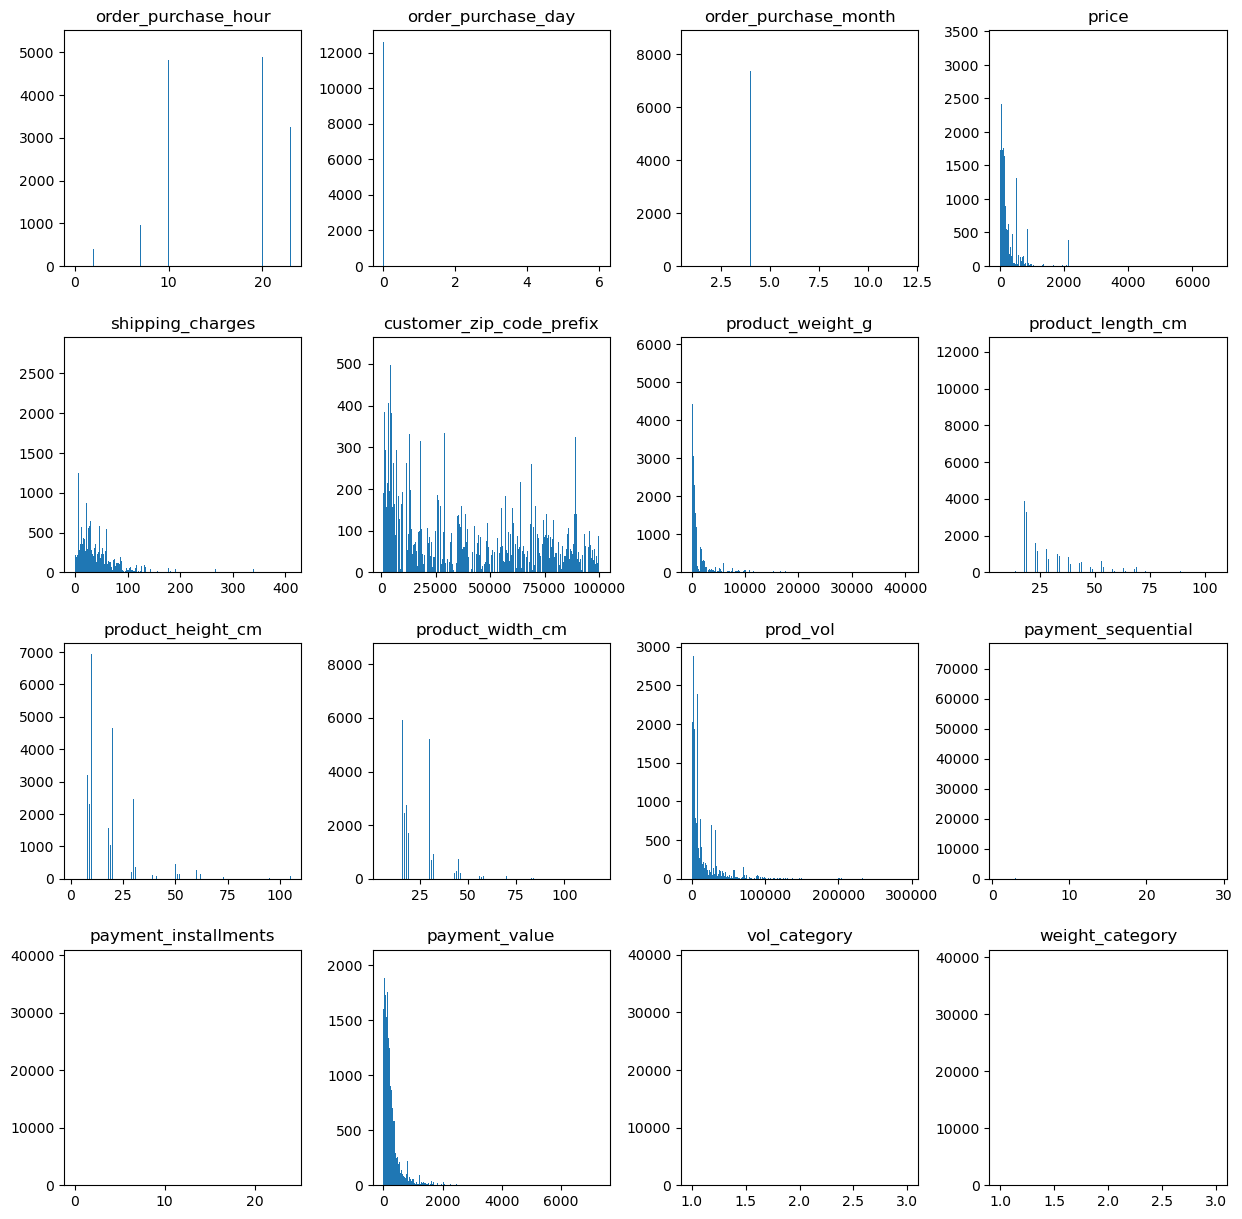

In [26]:
df_tr.hist(figsize=(15, 15), grid=False, bins=1000)

##### Categorical features

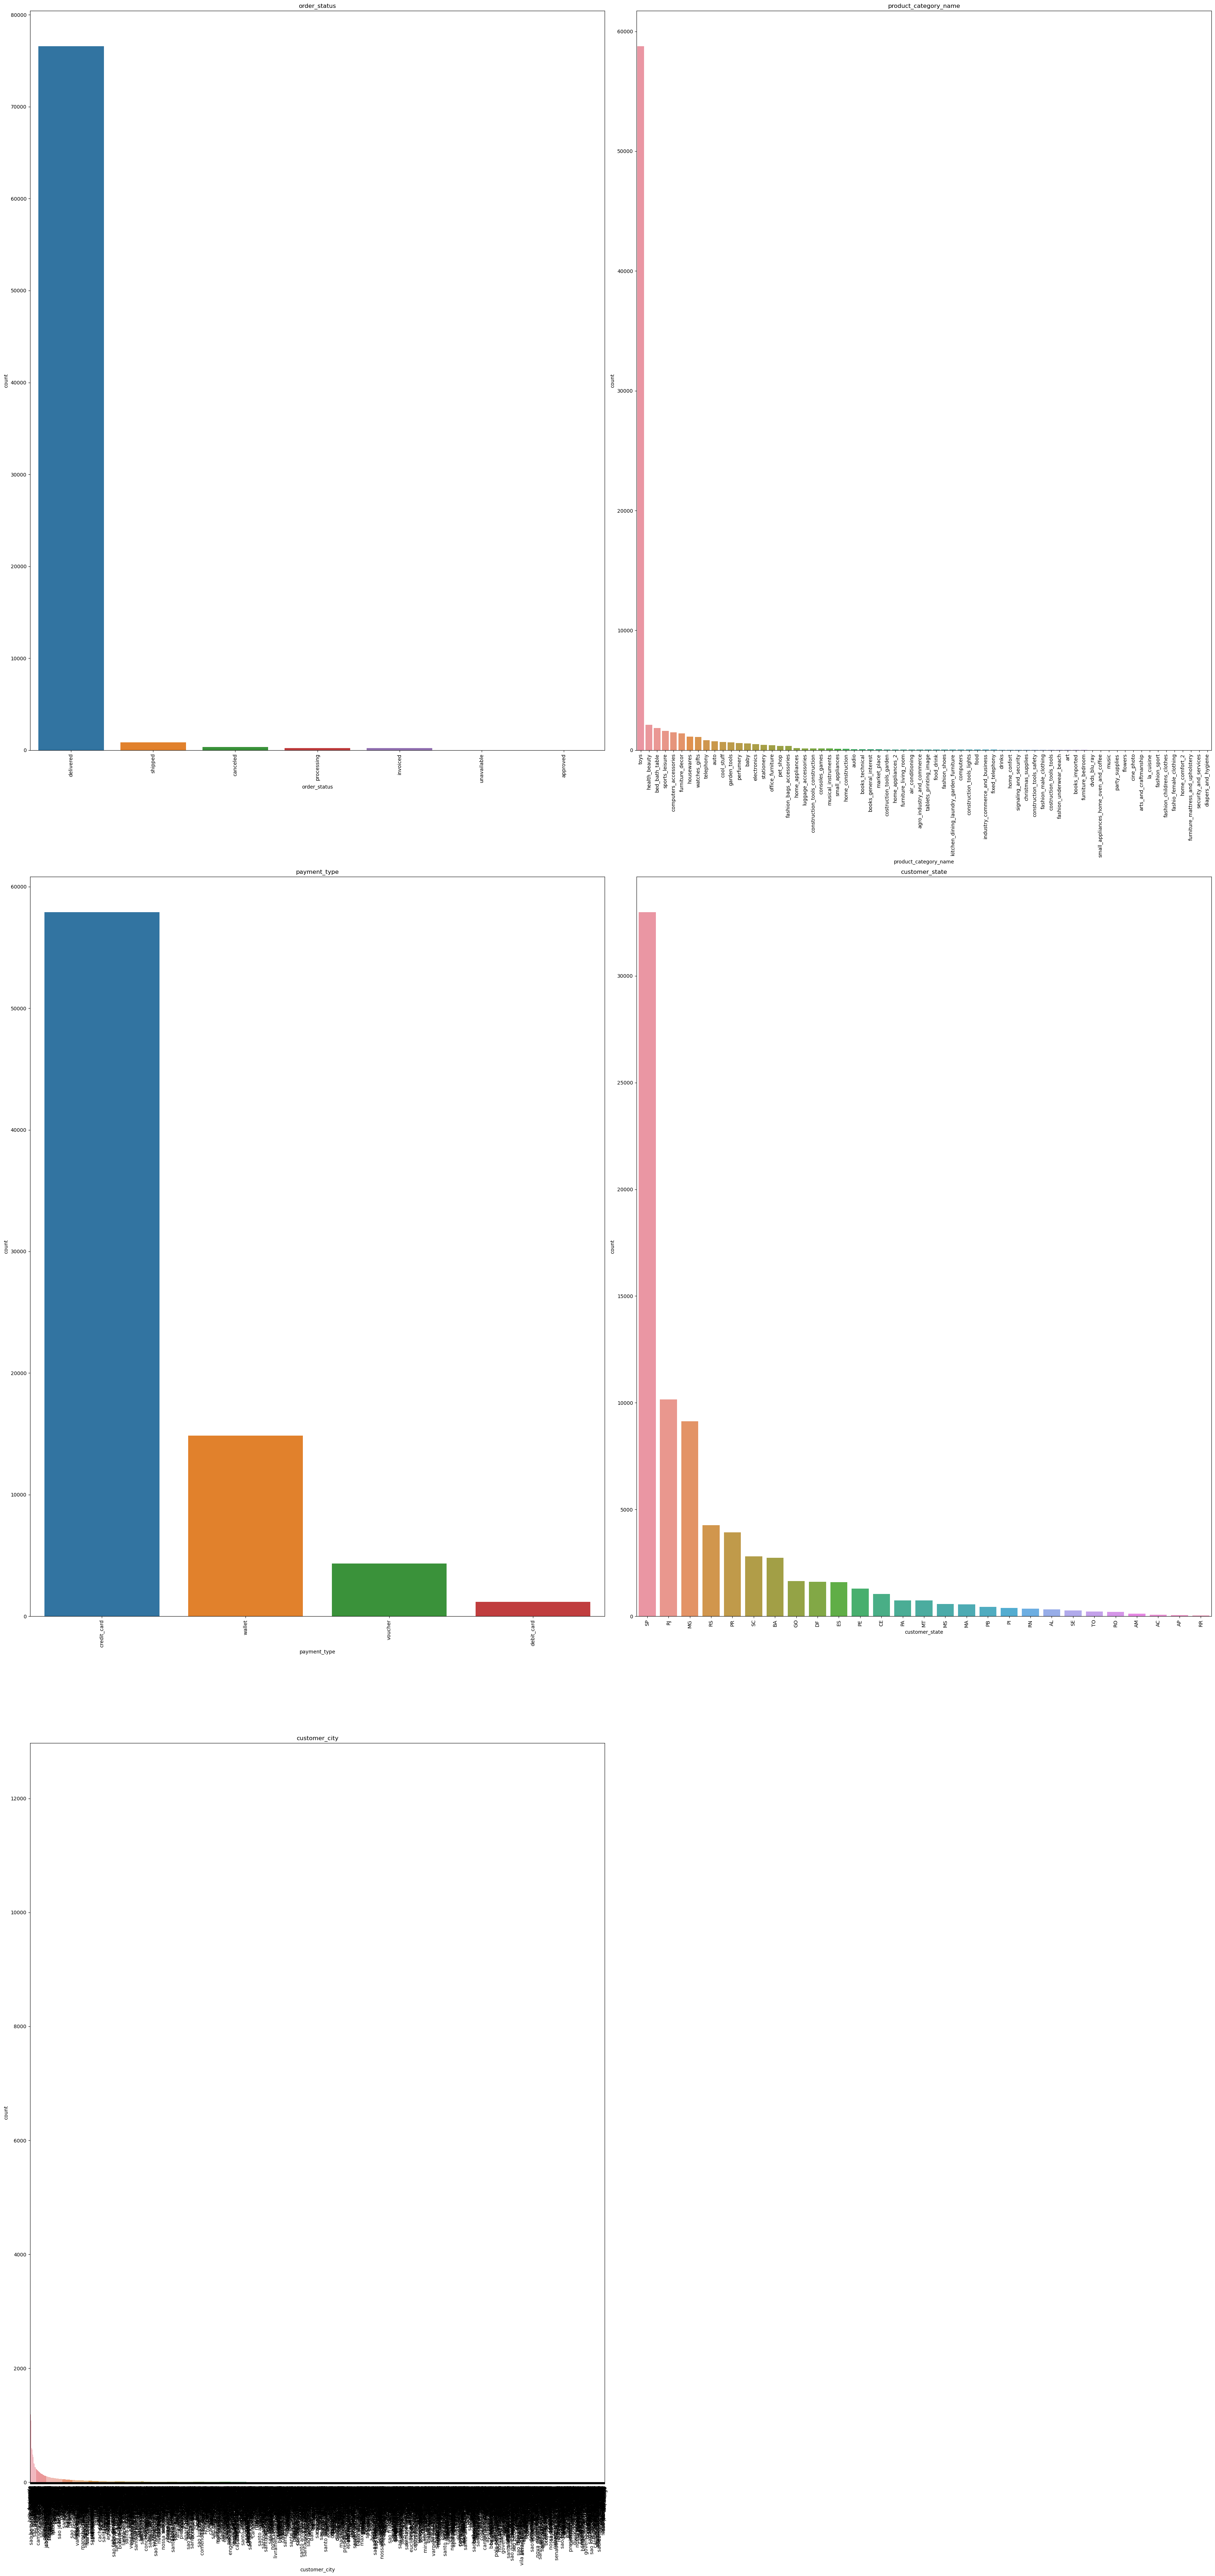

In [27]:
n_categories = 5
n_cols = 2
n_rows = n_categories // n_cols + (n_categories % n_cols > 0)
cat = df_tr[
    [
        "order_status",
        "product_category_name",
        "payment_type",
        "customer_state",
        "customer_city",
    ]
]
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 17, n_rows * 24))
axs = axs.flatten()
for i, column in enumerate(cat.columns):
    # Plot each category in its subplot
    sns.barplot(
        x=cat[column].value_counts().index, y=cat[column].value_counts(), ax=axs[i]
    )
    axs[i].set_title(column)
    # Get current x-tick labels and set them with a 90-degree rotation
    labels = axs[i].get_xticklabels()
    axs[i].set_xticklabels(labels, rotation=90)

for i in range(n_categories, len(axs)):
    axs[i].set_visible(False)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

### Correlation
#### Bivariate analysis

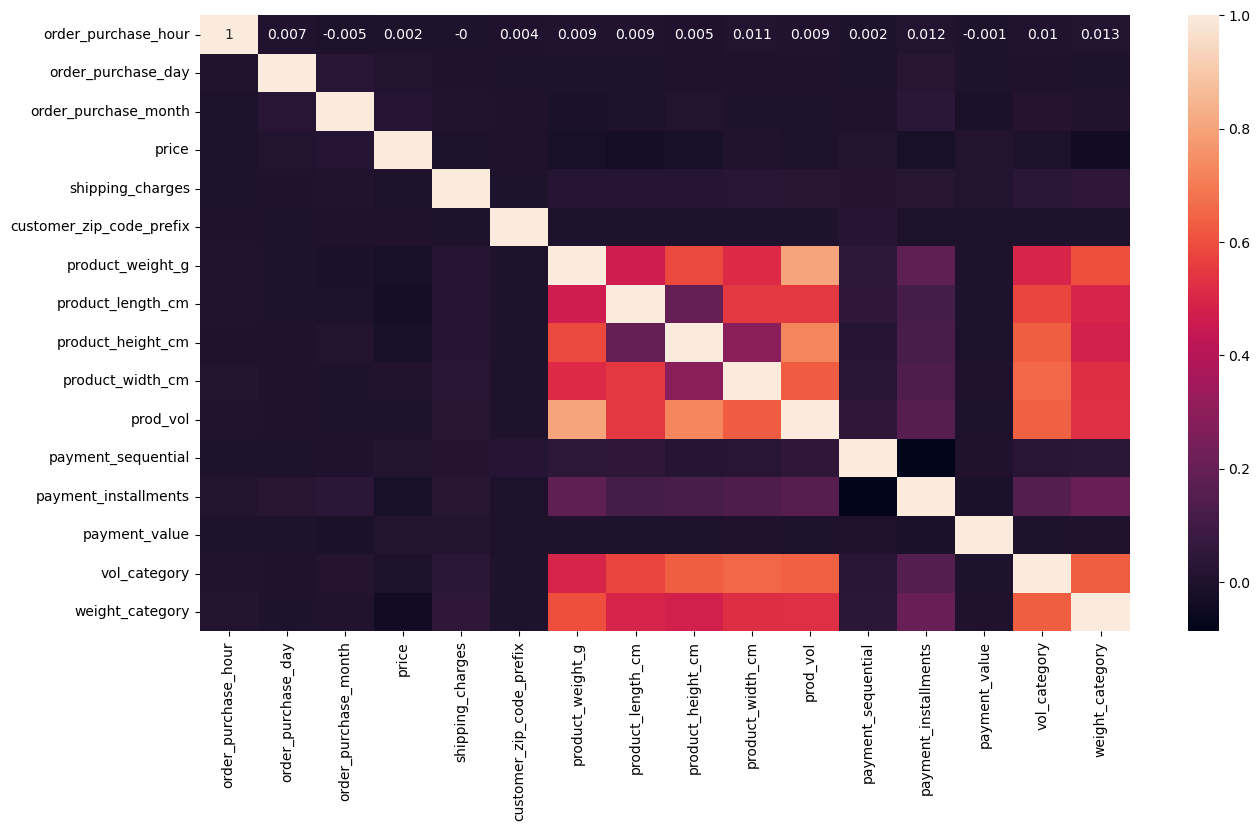

In [28]:
corr = df_tr.corr(numeric_only = True).round(3)
plt.figure(figsize= (15,8))
sns.heatmap(corr, annot= True);

### Convert categorical data to numerical

In [29]:
label_encoder = LabelEncoder()
zip_code = pd.concat([df_tr['customer_zip_code_prefix'], df_ts['customer_zip_code_prefix']])
label_encoder.fit(zip_code)
df_tr['customer_zip_code_prefix']= label_encoder.transform(df_tr['customer_zip_code_prefix'])
df_ts['customer_zip_code_prefix']= label_encoder.transform(df_ts['customer_zip_code_prefix'])

custom_city = pd.concat([df_tr['customer_city'], df_ts['customer_city']])
label_encoder.fit(custom_city)
df_tr['customer_city']= label_encoder.transform(df_tr['customer_city'])
df_ts['customer_city']= label_encoder.transform(df_ts['customer_city'])

custom_state = pd.concat([df_tr['customer_state'], df_ts['customer_state']])
label_encoder.fit(custom_state)
df_tr['customer_state']= label_encoder.transform(df_tr['customer_state'])
df_ts['customer_state']= label_encoder.transform(df_ts['customer_state'])

sell_id = pd.concat([df_tr['seller_id'], df_ts['seller_id']])
label_encoder.fit(sell_id)
df_tr['seller_id']= label_encoder.transform(df_tr['seller_id'])
df_ts['seller_id']= label_encoder.transform(df_ts['seller_id'])

cat_name = pd.concat([df_tr['product_category_name'], df_ts['product_category_name']])
label_encoder.fit(cat_name)
df_tr['product_category_name']= label_encoder.transform(df_tr['product_category_name'])
df_ts['product_category_name']= label_encoder.transform(df_ts['product_category_name'])


In [30]:
print_df_info(df_tr)

total rows=78278
                      column    dtype  num_null  num_unique
0               order_status   object         0           7
1        order_purchase_hour    int32         0          24
2         order_purchase_day    int32         0           7
3       order_purchase_month    int32         0          12
4                  seller_id    int64         0        2929
5                      price  float64         0        5235
6           shipping_charges  float64         0        6327
7   customer_zip_code_prefix    int64         0       13930
8              customer_city    int64         0        3735
9             customer_state    int64         0          27
10     product_category_name    int64         0          71
11          product_weight_g  float64        14        2021
12         product_length_cm  float64        14         100
13         product_height_cm  float64        14         102
14          product_width_cm  float64        14          94
15                  pro

In [31]:
df_tr = pd.get_dummies(df_tr, columns = ['payment_type','order_status'])
print_df_info(df_tr)
df_tr.info()

total rows=78278
                      column    dtype  num_null  num_unique
0        order_purchase_hour    int32         0          24
1         order_purchase_day    int32         0           7
2       order_purchase_month    int32         0          12
3                  seller_id    int64         0        2929
4                      price  float64         0        5235
5           shipping_charges  float64         0        6327
6   customer_zip_code_prefix    int64         0       13930
7              customer_city    int64         0        3735
8             customer_state    int64         0          27
9      product_category_name    int64         0          71
10          product_weight_g  float64        14        2021
11         product_length_cm  float64        14         100
12         product_height_cm  float64        14         102
13          product_width_cm  float64        14          94
14                  prod_vol  float64        14        4179
15        payment_seque

In [32]:
df_ts = pd.get_dummies(df_ts, columns = ['payment_type'])
print_df_info(df_ts)
df_ts.info()

total rows=35787
                      column    dtype  num_null  num_unique
0        order_purchase_hour    int32         0          24
1         order_purchase_day    int32         0           7
2       order_purchase_month    int32         0          12
3                  seller_id    int64         0        2476
4                      price  float64         0        3682
5           shipping_charges  float64         0        4801
6   customer_zip_code_prefix    int64         0       10952
7              customer_city    int64         0        2804
8             customer_state    int64         0          27
9      product_category_name    int64         0          67
10          product_weight_g  float64         8        1618
11         product_length_cm  float64         8          99
12         product_height_cm  float64         8         100
13          product_width_cm  float64         8          87
14                  prod_vol  float64         8        3234
15        payment_seque

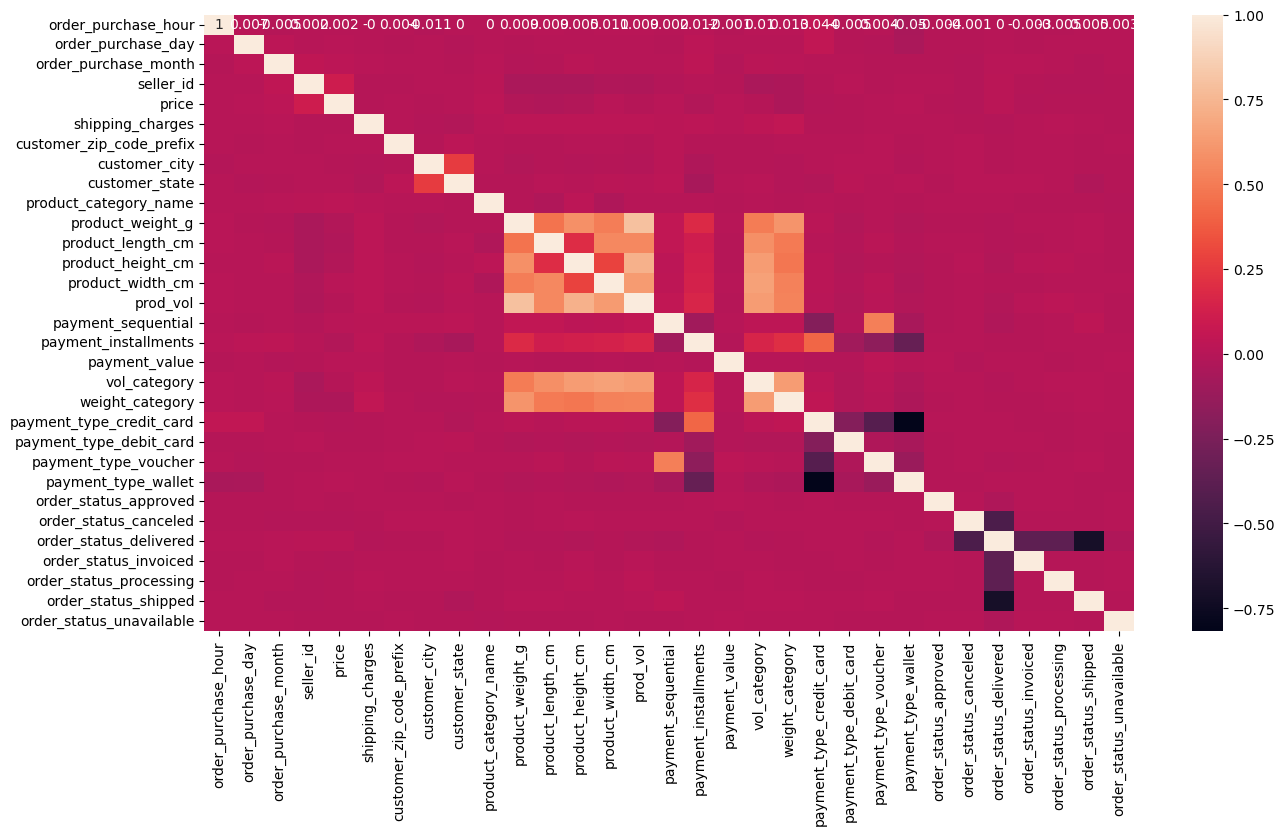

In [33]:
corr = df_tr.corr(numeric_only = True).round(3)
plt.figure(figsize= (15,8))
sns.heatmap(corr, annot= True);

* We can remove payment_installments and payment_sequential columns as they have strong correlation with payment_type column

# Feature selection, modeling for credit card payments target

## Feature Selection (RFE) including engineered features

In [34]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78278 entries, 0 to 78277
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_purchase_hour       78278 non-null  int32  
 1   order_purchase_day        78278 non-null  int32  
 2   order_purchase_month      78278 non-null  int32  
 3   seller_id                 78278 non-null  int64  
 4   price                     78278 non-null  float64
 5   shipping_charges          78278 non-null  float64
 6   customer_zip_code_prefix  78278 non-null  int64  
 7   customer_city             78278 non-null  int64  
 8   customer_state            78278 non-null  int64  
 9   product_category_name     78278 non-null  int64  
 10  product_weight_g          78264 non-null  float64
 11  product_length_cm         78264 non-null  float64
 12  product_height_cm         78264 non-null  float64
 13  product_width_cm          78264 non-null  float64
 14  prod_v

In [35]:
target_feature = 'payment_type_credit_card'
remove_features = ['payment_type_debit_card', 'payment_type_wallet', 'payment_type_voucher', 'payment_sequential', 'payment_installments']

In [36]:
X = df_tr.drop(columns=([target_feature]+remove_features))
y = df_tr[target_feature]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
numerical_features = ['price','shipping_charges','product_weight_g', 'product_length_cm','product_height_cm','product_width_cm','prod_vol','payment_value']

In [38]:
preprocessor = ColumnTransformer(
    [("scaler", StandardScaler(), numerical_features)],
    remainder='passthrough'
)

In [39]:
# Create the RFE object with LightGBM as the estimator
# and specifying the number of features to select
n_features_to_select = 12
rfe = RFE(estimator=lgb.LGBMRegressor(), n_features_to_select=n_features_to_select, step=1)

# Create a pipeline that includes preprocessing and RFE
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfe', rfe)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Get the feature names after preprocessing
preprocessed_feature_names = [str(i).removeprefix('scaler__').removeprefix('remainder__') for i in pipeline.named_steps['preprocessor'].get_feature_names_out()]

# Extract the selected features from the preprocessed data
selected_features = [preprocessed_feature_names[i] for i in range(len(preprocessed_feature_names)) if pipeline.named_steps['rfe'].support_[i]]
print('Chosen best {num_features} features by RFE:'.format(num_features=n_features_to_select), selected_features)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 62622, number of used features: 23
[LightGBM] [Info] Start training from score 0.738303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 62622, number of used features: 23
[LightGBM] [Info] Start training from score 0.738303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [40]:
print_df_info(df_tr)

total rows=78278
                      column    dtype  num_null  num_unique
0        order_purchase_hour    int32         0          24
1         order_purchase_day    int32         0           7
2       order_purchase_month    int32         0          12
3                  seller_id    int64         0        2929
4                      price  float64         0        5235
5           shipping_charges  float64         0        6327
6   customer_zip_code_prefix    int64         0       13930
7              customer_city    int64         0        3735
8             customer_state    int64         0          27
9      product_category_name    int64         0          71
10          product_weight_g  float64        14        2021
11         product_length_cm  float64        14         100
12         product_height_cm  float64        14         102
13          product_width_cm  float64        14          94
14                  prod_vol  float64        14        4179
15        payment_seque

Insights:
* The columns height, width, length aren't that useful as we have volumn of the product, will remove them
* The order status columns aren't useful, will remove it
* Very few rows have nan values for product weight and volumn. We can drop those rows

In [41]:
df_tr.drop(columns=['product_length_cm','product_height_cm','product_width_cm',
 'order_status_approved',
 'order_status_canceled',
 'order_status_delivered',
 'order_status_invoiced',
 'order_status_processing',
 'order_status_shipped',
 'order_status_unavailable'], inplace=True)

In [42]:
df_tr.dropna(inplace=True)
df_tr.reset_index(drop=True, inplace=True)
print_df_info(df_tr)
df_tr.info()

total rows=78264
                      column    dtype  num_null  num_unique
0        order_purchase_hour    int32         0          24
1         order_purchase_day    int32         0           7
2       order_purchase_month    int32         0          12
3                  seller_id    int64         0        2929
4                      price  float64         0        5234
5           shipping_charges  float64         0        6327
6   customer_zip_code_prefix    int64         0       13929
7              customer_city    int64         0        3734
8             customer_state    int64         0          27
9      product_category_name    int64         0          71
10          product_weight_g  float64         0        2020
11                  prod_vol  float64         0        4178
12        payment_sequential    int64         0          28
13      payment_installments    int64         0          24
14             payment_value  float64         0       25518
15              vol_cat

#### Prep for Modeling

In [43]:
results = []
feature_importances = {}

In [44]:
# Define the Keras model
def build_keras_model(input_dim, optimizer='adam', activation='relu', first_layer_nodes=128, second_layer_nodes=64, third_layer_nodes=32):
    model = Sequential()
    model.add(Dense(first_layer_nodes, input_dim=input_dim, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(second_layer_nodes, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(third_layer_nodes, activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

numerical_features = ['price','shipping_charges','product_weight_g','prod_vol','payment_value']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
    ],
    remainder='passthrough'
)

X = df_tr.drop(columns=([target_feature]+remove_features))
y = df_tr[target_feature]

# Fit the preprocessor and get the number of output features
preprocessor.fit(X)
num_features_after_preprocessing = preprocessor.transform(X).shape[1]

keras_reg_params = {
    'build_fn': build_keras_model,
    'input_dim': num_features_after_preprocessing,
    'epochs': 100,
    'batch_size': 32,
    'verbose': 0,
    'optimizer': 'adam',  
    'activation': 'relu', 
    'first_layer_nodes': 128,
    'second_layer_nodes': 64,
    'third_layer_nodes': 32
}
keras_model = KerasRegressor(**keras_reg_params)

In [45]:
# set up dataframes for storing results
models = {
    "Dummy Regressor": DummyRegressor(strategy='mean'), 
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(verbose=3),
    "CatBoost": CatBoostRegressor(verbose=3),
    "XGBoost": xgb.XGBRegressor(n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(),
    "Neural Network": MLPRegressor(max_iter=1000), 
    "Random Forest": RandomForestRegressor(),
    "Keras Neural Network": keras_model
}

In [46]:
params = {
    "Gradient Boosting": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    "CatBoost": {
        'model__iterations': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__depth': [6, 8, 10, 12], 
        'model__l2_leaf_reg': [1, 3, 5, 7, 9],
        'model__subsample': [0.6, 0.8, 1.0]
    },
    "XGBoost": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    "Decision Tree": {
        'model__max_depth': [3, 5, 10],
        'model__min_samples_split': [2, 10, 20]
    },
    "Neural Network": {
        'model__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'model__activation': ['tanh', 'relu'],
        'model__solver': ['sgd', 'adam'],
        'model__alpha': [0.0001, 0.05],
        'model__learning_rate': ['constant','adaptive'],
    }, 
    "Random Forest": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 10],
        'model__min_samples_split': [2, 10, 20]
    }, 
    "Keras Neural Network": {
        'model__optimizer': ['adam', 'rmsprop'],
        'model__batch_size': [32, 64],
        'model__epochs': [100, 200],
        'model__activation': ['relu', 'tanh'],
        'model__first_layer_nodes': [128, 256],
        'model__second_layer_nodes': [64, 128],
        'model__third_layer_nodes': [32, 64]
    }
}

### Modeling

In [49]:
def evaluate_models(df, target_feature, remove_features, numerical_features):

    print(datetime.now())  # print system time to track duration of the process

    X = df_tr.drop(columns=([target_feature]+remove_features))
    y = df_tr[target_feature]

    # For non-time series models, regular split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    if df[target_feature].min() < 0:
        raise ValueError("Negative values found in target variable.")

    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), numerical_features),
        ],
        remainder='passthrough'
    )

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        grid_search_time, fit_time, best_model = None, None, model

        if model_name in params:
            pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)])
            start_time = time()
            grid_search = RandomizedSearchCV(pipeline, params[model_name], scoring='neg_mean_squared_log_error', cv=3, n_iter=10, n_jobs=-1, verbose=3, random_state=42)
            grid_search.fit(X_train, y_train)
            grid_search_time = (time() - start_time) / 60
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best score: {grid_search.best_score_}")
            print(f"Best estimator: {grid_search.best_estimator_}")
            print(f"Time taken for {model_name} grid search: {grid_search_time:.2f} minutes")

            best_model = grid_search.best_estimator_

            start_time = time()
            best_model.fit(X_train, y_train)
            fit_time = (time() - start_time) / 60 
            print(f"Time taken for {model_name} fitting: {fit_time:.2f} minutes")
        else:
            pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('model', model)])
            start_time = time()
            pipeline.fit(X_train, y_train)
            fit_time = (time() - start_time) / 60 
            print(f"Time taken for {model_name} fitting: {fit_time:.2f} minutes")
            best_model = pipeline

        # Save the trained model
        joblib.dump(best_model, f"{model_name}_best_model.pkl")

        # Predictions for train and validation sets
        train_predictions = best_model.predict(X_train)
        val_predictions = best_model.predict(X_val)
        test_predictions = best_model.predict(X_test)

        # Debug: Check predictions for negative values
        negative_train_predictions = train_predictions[train_predictions < 0]
        negative_val_predictions = val_predictions[val_predictions < 0]
        negative_test_predictions = test_predictions[test_predictions < 0]
        if len(negative_train_predictions) > 0 or len(negative_val_predictions) > 0 or len(negative_test_predictions) > 0:
            print(f"Negative predictions found for model {model_name}")
            if len(negative_train_predictions) > 0:
                print(f"Negative train predictions: {negative_train_predictions}")
            if len(negative_val_predictions) > 0:
                print(f"Negative validation predictions: {negative_val_predictions}")
            # Clip predictions to ensure non-negative values
            train_predictions = np.clip(train_predictions, 0, None)
            val_predictions = np.clip(val_predictions, 0, None)
            test_predictions = np.clip(test_predictions, 0, None)

        
        train_mse = mean_squared_error(y_train, train_predictions)
        train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_predictions))
        train_r2 = r2_score(y_train, train_predictions)
        val_mse = mean_squared_error(y_val, val_predictions)
        val_rmsle = np.sqrt(mean_squared_log_error(y_val, val_predictions))
        val_r2 = r2_score(y_val, val_predictions)
        test_mse = mean_squared_error(y_test, test_predictions)
        test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_predictions))
        test_r2 = r2_score(y_test, test_predictions)
        print(f"Train MSE: {train_mse:.2f}")
        print(f"Train R2: {train_r2:.2f}")
        print(f"Train RMSLE: {train_rmsle:.4f}")
        print(f"Validation MSE: {val_mse:.2f}")
        print(f"Validation R2: {val_r2:.2f}")
        print(f"Validation RMSLE: {val_rmsle:.4f}")
        print(f"Test MSE: {test_mse:.2f}")
        print(f"Test R2: {test_r2:.2f}")
        print(f"Test RMSLE: {test_rmsle:.4f}")

        results.append({
            "Model": model_name,
            "Train MSE": train_mse,
            "Train R2": train_r2,
            "Train RMSLE": train_rmsle,
            "Train RMSLE*100": 100 * train_rmsle,
            "Validation MSE": val_mse,
            "Validation R2": val_r2,
            "Validation RMSLE": val_rmsle,
            "Validation RMSLE*100": 100 * val_rmsle,
            "Test MSE": test_mse,
            "Test R2": test_r2,
            "Test RMSLE": test_rmsle,
            "Test RMSLE*100": 100 * test_rmsle,
            "Grid Search Time (s)": grid_search_time,
            "Fit Time (s)": fit_time,
            "Best Params": best_model.get_params() if model_name in params else "N/A"
        })
        
        preprocessed_feature_names = [str(i).removeprefix('scaler__').removeprefix('remainder__') for i in pipeline.named_steps['preprocessor'].get_feature_names_out()]

        perm_importance = permutation_importance(best_model['model'], preprocessor.transform(X_val), y_val, n_repeats=10, random_state=42)
        importance_df = pd.DataFrame({
            'Feature': list(preprocessed_feature_names),
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False)

        feature_importances[model_name] = importance_df  # Save the feature importances to the dictionary
        
        top_features = importance_df.head(20)
        print(top_features)
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Permutation Importance for {model_name}')
        plt.show()

    results_df = pd.DataFrame(results)
    print(results_df)
    
    print(datetime.now())  # Track end time of process 
    
    return results_df, feature_importances

2024-08-26 05:22:29.968413
Evaluating Dummy Regressor...
Time taken for Dummy Regressor fitting: 0.00 minutes
Train MSE: 0.19
Train R2: 0.00
Train RMSLE: 0.3070
Validation MSE: 0.19
Validation R2: -0.00
Validation RMSLE: 0.3068
Test MSE: 0.19
Test R2: -0.00
Test RMSLE: 0.3069
                     Feature  Importance
0                      price         0.0
1           shipping_charges         0.0
2           product_weight_g         0.0
3                   prod_vol         0.0
4              payment_value         0.0
5        order_purchase_hour         0.0
6         order_purchase_day         0.0
7       order_purchase_month         0.0
8                  seller_id         0.0
9   customer_zip_code_prefix         0.0
10             customer_city         0.0
11            customer_state         0.0
12     product_category_name         0.0
13              vol_category         0.0
14           weight_category         0.0


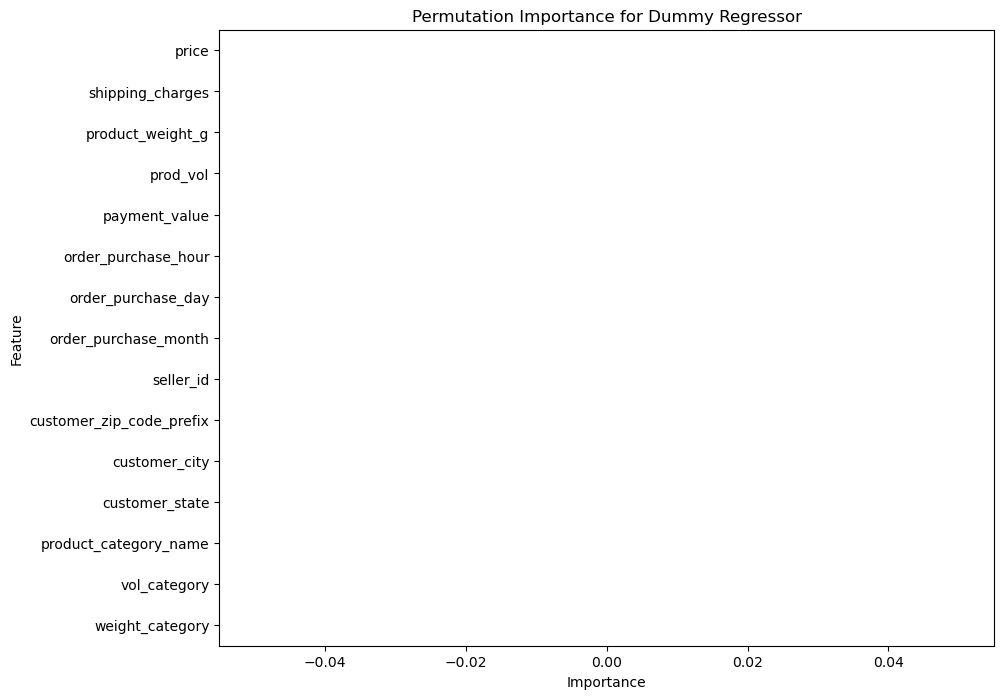

Evaluating Linear Regression...
Time taken for Linear Regression fitting: 0.00 minutes
Train MSE: 0.19
Train R2: 0.01
Train RMSLE: 0.3060
Validation MSE: 0.19
Validation R2: 0.00
Validation RMSLE: 0.3060
Test MSE: 0.19
Test R2: 0.00
Test RMSLE: 0.3062
                     Feature  Importance
5        order_purchase_hour    0.004360
6         order_purchase_day    0.003754
14           weight_category    0.003023
0                      price    0.000376
4              payment_value    0.000258
10             customer_city    0.000163
1           shipping_charges    0.000149
12     product_category_name    0.000143
13              vol_category    0.000106
2           product_weight_g    0.000079
11            customer_state    0.000068
9   customer_zip_code_prefix   -0.000010
3                   prod_vol   -0.000068
7       order_purchase_month   -0.000110
8                  seller_id   -0.000444


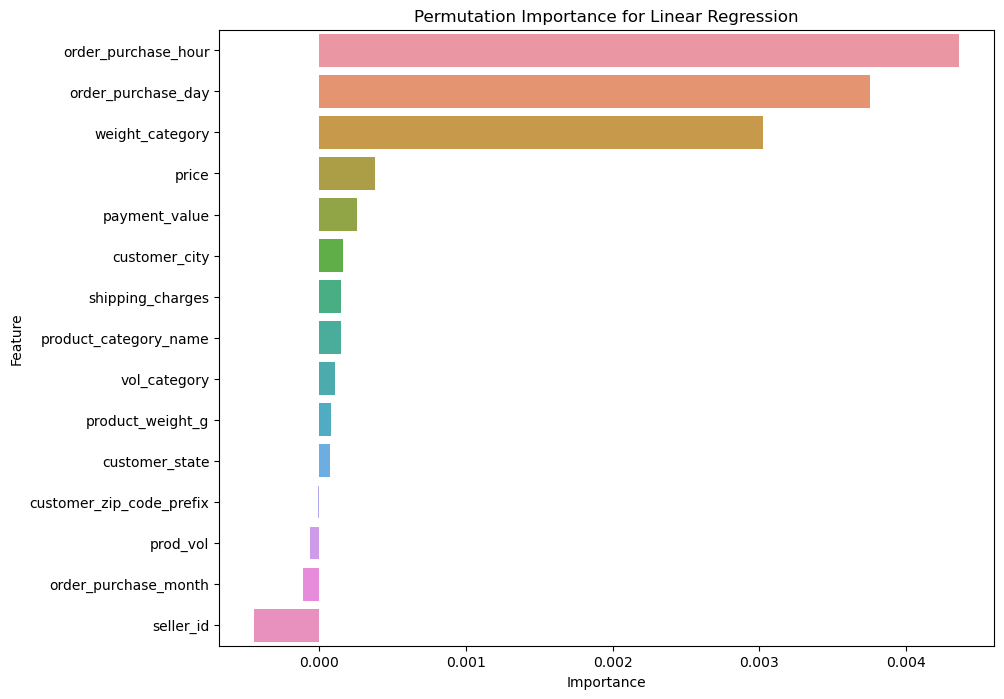

Evaluating Gradient Boosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:

numerical_features = ['price','shipping_charges','product_weight_g','prod_vol','payment_value']

results_df, feature_importances = evaluate_models(df_tr, target_feature, remove_features, numerical_features)

In [ ]:
time_series_results = {
    "Model": "Time Series XGBoost",
    "Train MSE": 55011.39,
    "Train R2": 0.68,
    "Train RMSLE": 0.9023,
    "Train RMSLE*100": 90.23,
    "Validation MSE": 50566.19,
    "Validation R2": 0.63,
    "Validation RMSLE": 0.9155,
    "Validation RMSLE*100": 91.55,
    "Test MSE": 49370.23,
    "Test R2": 0.63,
    "Test RMSLE": 0.9329,
    "Test RMSLE*100": 93.29,
    "Grid Search Time (s)": 0.37,
    "Fit Time (s)": 0.03,
    "Best Params": {
        'model__subsample': 1.0,
        'model__n_estimators': 200,
        'model__max_depth': 5,
        'model__learning_rate': 0.01,
        'model__colsample_bytree': 0.6
    }
}

In [ ]:
results.append(time_series_results)

In [ ]:
# Save the feature importances and results
joblib.dump(feature_importances, 'feature_importances.pkl')

results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)

## Results Analysis

In [ ]:
results_df.head(10)

In [ ]:
heatmap_data = results_df[['Model', 'Train RMSLE', 'Validation RMSLE', 'Test RMSLE', 'Train R2', 'Validation R2', 'Test R2']]
heatmap_data.set_index('Model', inplace=True)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3g', linewidths=0.5, linecolor='black')
plt.title('Model Performance Metrics')
plt.savefig('images/model_performance_metrics.png')
plt.xlabel('Metrics')
plt.ylabel('Model')
plt.show()

### Model Comparison (Performance Metric: RMSLE)

In [ ]:
sorted_df = results_df.sort_values(by='Validation RMSLE')
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Validation RMSLE", data=sorted_df, palette='YlGnBu')
plt.title('Neural Network has the lowest Validation RMSLE')
plt.suptitle('Model Comparison: Validation RMSLE')
plt.ylabel('Validation RMSLE')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.savefig('images/validation_rmsle.png')
plt.show()

In [ ]:
rmsle_df = results_df.melt(id_vars=['Model'], value_vars=['Train RMSLE', 'Validation RMSLE', 'Test RMSLE'],
                                    var_name='Set', value_name='RMSLE')
rmsle_df_sorted = rmsle_df.set_index('Model').loc[sorted_df['Model']].reset_index()
plt.figure(figsize=(14, 8))
sns.barplot(x='RMSLE', y='Model', hue='Set', data=rmsle_df_sorted, palette='viridis', ci=None)
plt.title('Model Comparison: Train, Validation, and Test Set RMSLE', fontsize=14)
plt.xlabel('RMSLE value', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.legend(title='Comparison', fontsize=12, title_fontsize=10, loc='upper right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('images/rmsle_comparison.png')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Best model analysis

In [ ]:
best_model_name = results_df.loc[results_df['Validation RMSLE'].idxmin()]['Model']
print(f"Best Model based on validation RMSLE: {best_model_name}")

In [ ]:
# Load the best model
best_model = joblib.load(f"{best_model_name}_best_model.pkl")
best_model

### Shap-Analysis Neural Network

In [ ]:
from sklearn.cluster import KMeans

X = df.drop(columns=['num_orders'])
y = df['num_orders']

numerical_features = ['checkout_price', 'discount_percent', 'op_area', 'week', 'email_promo', 'homepage_featured', 'discount_percent_mean_ts', 'checkout_price_mean_ts', 'email_promo_mean_ts', 'homepage_featured_mean_ts', 'center_week_count', 'city_week_count', 'region_week_count', 'center_type_week_count', 'meal_category_week_count', 'meal_homepage_featured_mean', 'cuisine_week_checkout_price_ratio']
categorical_features = ['meal', 'meal_category', 'cuisine', 'city', 'region', 'center', 'center_type']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessor for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Define the full pipeline including preprocessing and the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', best_model.named_steps['model'])])

# Transform the training data
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
print("Transformed X_train shape:", X_train_transformed.shape)

# Print the feature names after transformation
transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
print("Transformed feature names:", transformed_feature_names)

# Perform k-means clustering on the transformed data
kmeans = KMeans(n_clusters=100, random_state=42).fit(X_train_transformed)  # Adjust the number of clusters as needed
X_train_summary = kmeans.cluster_centers_
print("Transformed X_train_summary shape:", X_train_summary.shape)

# Define a prediction wrapper function that works with the transformed data
def model_predict_transformed(data):
    return pipeline.named_steps['model'].predict(data)

# Create a SHAP explainer using the transformed data
explainer = shap.KernelExplainer(model_predict_transformed, X_train_summary)

# Compute SHAP values for a subset of the data
sample_data = X_train.sample(100, random_state=42)
sample_data_transformed = pipeline.named_steps['preprocessor'].transform(sample_data)
shap_values = explainer.shap_values(sample_data_transformed)

# Create a DataFrame for transformed features
X_transformed = pd.DataFrame(pipeline.named_steps['preprocessor'].transform(X), columns=transformed_feature_names)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_transformed.loc[sample_data.index])

In [ ]:
# Generate SHAP summary bar plot
shap.summary_plot(shap_values, X_transformed.loc[sample_data.index], plot_type="bar")

### Actual vs Predicted Number of Orders

In [ ]:
# Plot the predicted values vs the actual values
y_pred = pipeline.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Number of Orders')
plt.show()

### Residual plot

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()